# House Prices - Practice Feature Engineering

In this project, we will work on the Kaggle House Prices Competition which uses the Ames Housing dataset, compiled by Dean De Cock for use in data science education:

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview

This dataset with 79 explanatory variables provides a great opportunity to practice some of the feature engineering techniques we have learned. The goal of the competition is to predict the sales price for each house. The submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price.  

## Data Acquisition

In [1]:
import pandas as pd
import numpy as np
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print ("Train data shape:", train.shape)
print ("Test data shape:", test.shape)

Train data shape: (1460, 81)
Test data shape: (1459, 80)


As seen, the data provided on Kaggle has been divided into 2 parts of about equal sizes for training and test data. Test data does not include the final sale price columns, which is the feature we are trying to predict.

In [2]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


We can already see from the data that most of the features are complete, i.e. do not include any null values. The information on these features are provided on the competition website in the data_description.txt file. Some of the features and their keys are defined as:

| Variable | Definition | Key |
| :- | :- | :- |
| Street | Type of road access to property | Grvl = Gravel, Pave = Paved |
| OverallQual | Rates the overall material and finish of the house | 1 (very poor) to 10 (very excellent) |
| YearBuilt | Original construction date |
| TotRmsAbvGrd | Total rooms above grade (does not include bathrooms)
| GarageCars | Size of garage in car capacity |

## Target Data Transformation

In [3]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Looking at the skewness, we can see that the distribution has a longer tail on the right meaning it is positively skewed:

Skew is: 1.8828757597682129


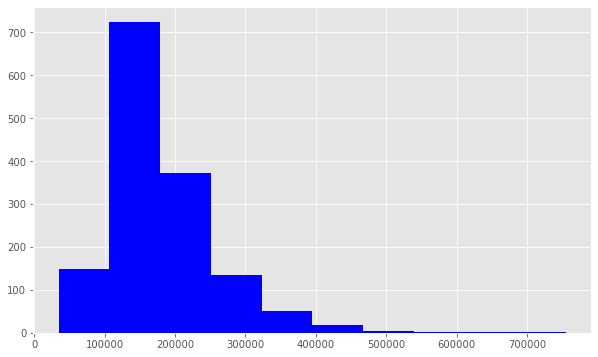

In [4]:
import matplotlib.pyplot as plt
plt.style.use(style='ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

print ("Skew is:", train.SalePrice.skew())
plt.hist(train.SalePrice, color='blue')
plt.show()

In order to lower the skewness and get the data closer to normal distribution, which is more suitable for use with linear regression, we will transform the Sale Price using the logarithm function:

Skew is: 0.12133506220520406


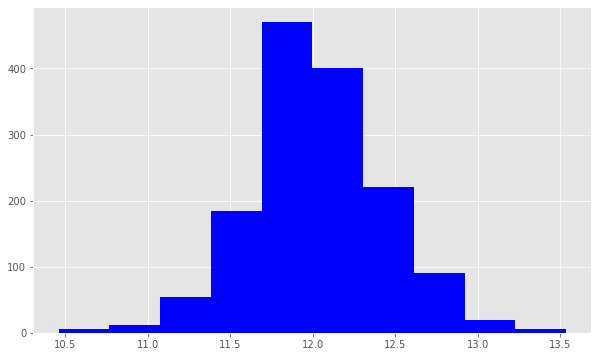

In [5]:
target = np.log(train.SalePrice)
print ("Skew is:", target.skew())
plt.hist(target, color='blue')
plt.show()

As seen, the skewness is lowered to about 0.12, which is a lot closer to normal distribution, which would have 0 skewness.

## Numerical Features

In [6]:
numeric_features = train.select_dtypes(include=[np.number])
numeric_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   OverallQual    1460 non-null   int64  
 5   OverallCond    1460 non-null   int64  
 6   YearBuilt      1460 non-null   int64  
 7   YearRemodAdd   1460 non-null   int64  
 8   MasVnrArea     1452 non-null   float64
 9   BsmtFinSF1     1460 non-null   int64  
 10  BsmtFinSF2     1460 non-null   int64  
 11  BsmtUnfSF      1460 non-null   int64  
 12  TotalBsmtSF    1460 non-null   int64  
 13  1stFlrSF       1460 non-null   int64  
 14  2ndFlrSF       1460 non-null   int64  
 15  LowQualFinSF   1460 non-null   int64  
 16  GrLivArea      1460 non-null   int64  
 17  BsmtFullBath   1460 non-null   int64  
 18  BsmtHalf

We can see that about half of the features (37 out of 79) are numerical, which allows us to check the correlation with the sale price:

In [7]:
corr = numeric_features.corr()
print (corr['SalePrice'].sort_values(ascending=False)[:5], '\n')
print (corr['SalePrice'].sort_values(ascending=False)[-5:])

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64 

YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


We can see that OverallQual has the highest correlation with Sale Price. In the data description, we see that this feature can have integer values between 1-10:

OverallQual: Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor

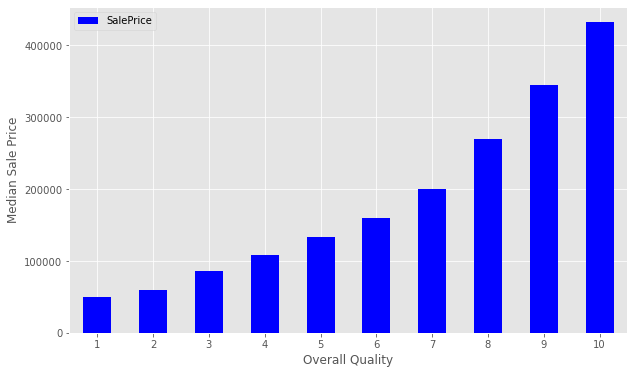

In [8]:
quality_pivot = train.pivot_table(index='OverallQual',
                  values='SalePrice', aggfunc=np.median)
quality_pivot.plot(kind='bar', color='blue')
plt.xlabel('Overall Quality')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

The plot confirms the positive correlation as we can see that the median price increases with the overall quality.

The next best correlated feature is the GrLivArea which is the above grade (ground) living area in square feet:

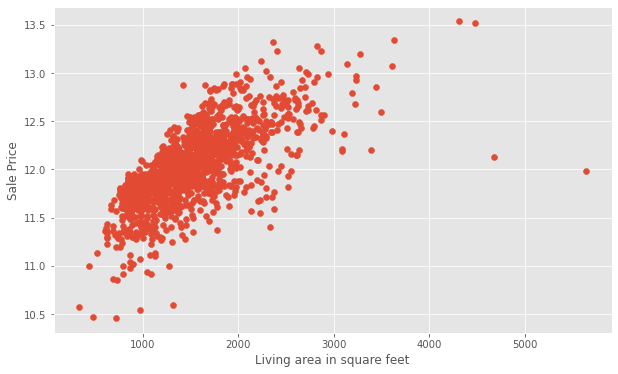

In [9]:
plt.scatter(x=train['GrLivArea'], y=target)
plt.ylabel('Sale Price')
plt.xlabel('Living area in square feet')
plt.show()

Except for a few outliers, we see that the sale price increases linearly as the living area increases. The same study can be carried out for garage area:

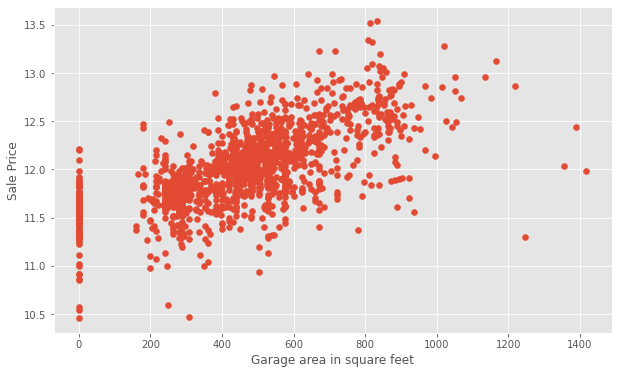

In [10]:
plt.scatter(x=train['GarageArea'], y=target)
plt.ylabel('Sale Price')
plt.xlabel('Garage area in square feet')
plt.show()

As seen, there are many houses with 0 garage area, meaning they do not have any garage. They cannot be dropped since the information is useful. However we can remove the few outliers that can affect our regression model:

In [11]:
train = train[(train['GrLivArea'] < 4000) & (train['GarageArea'] < 1200)]

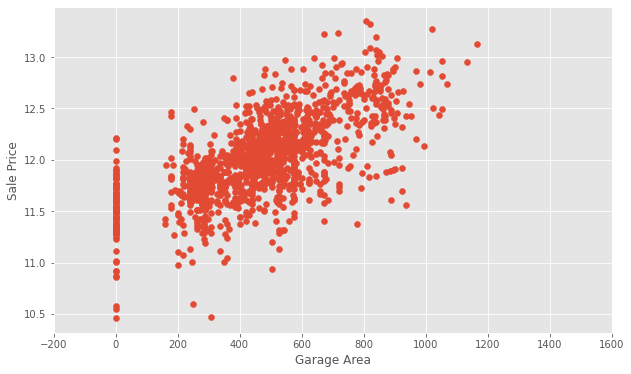

In [12]:
plt.scatter(x=train['GarageArea'], y=np.log(train.SalePrice))
plt.xlim(-200,1600) # This forces the same scale as before
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')
plt.show()

As seen, we have removed a total of 8 outliers from the training dataset:

In [13]:
len(train['SalePrice'])

1452

Lastly, we can fill the 3 columns with missing values with the most common value in that column:

In [14]:
numeric_features = train.select_dtypes(include=[np.number])
num_missing = numeric_features.isnull().sum()
fixable_numeric_cols = num_missing[num_missing > 0].sort_values()
fixable_numeric_cols

MasVnrArea       8
GarageYrBlt     81
LotFrontage    258
dtype: int64

In [15]:
## Compute the most common value for each column in `fixable_nmeric_missing_cols`.
replacement_values_dict = train[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
replacement_values_dict

{'MasVnrArea': 0.0, 'GarageYrBlt': 2005.0, 'LotFrontage': 60.0}

In [16]:
train = train.fillna(replacement_values_dict)
## Verify that every column has 0 missing values
numeric_features = train.select_dtypes(include=[np.number])
numeric_features.isnull().sum().value_counts()

0    38
dtype: int64

This confirms that the 38 numerical features do not have null values any more.

## Non-Numerical Features

The remaining non-numeric features have categorical values which are useful in identifying the houses. 

In [17]:
categoricals = train.select_dtypes(exclude=[np.number])
categoricals.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1452,1452,91,1452,1452,1452,1452,1452,1452,1452,...,1371,1371,1371,1371,1452,5,280,53,1452,1452
unique,5,2,2,4,4,2,5,3,25,9,...,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,Fa,MnPrv,Shed,WD,Normal
freq,1144,1447,50,921,1307,1451,1047,1375,225,1255,...,865,605,1303,1318,1332,2,156,48,1264,1195


We can see that some of the features have a lot of missing values. We can first examine the features with 5% or more missing values:

In [18]:
cat_num_missing = categoricals.isnull().sum()
cat_missing_cols = cat_num_missing[(cat_num_missing > len(train)/20)].sort_values()
cat_missing_cols

GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
FireplaceQu      689
Fence           1172
Alley           1361
MiscFeature     1399
PoolQC          1447
dtype: int64

As seen, there are 4 features related to the garage with the same number of missing values. The description for Garage Quality shows that a missing value in these columns indicates no garage:

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

The missing values for the other features have the same meaning, i.e. no fireplace or pool. So instead of dropping these features, we will fill the missing values with No to provide context.

In [19]:
cat_replace_dict = {}
for col in cat_missing_cols.index:
    cat_replace_dict[col] = 'No'
    
train = train.fillna(cat_replace_dict)
train['GarageType'].value_counts()

Attchd     865
Detchd     386
BuiltIn     87
No          81
Basment     19
CarPort      9
2Types       5
Name: GarageType, dtype: int64

The rest of the missing values are:

In [20]:
num_missing = train.isnull().sum()
rem_missing_cols = num_missing[num_missing > 0].sort_values()
rem_missing_cols

Electrical       1
MasVnrType       8
BsmtQual        37
BsmtCond        37
BsmtFinType1    37
BsmtExposure    38
BsmtFinType2    38
dtype: int64

The basement features with missing values can be filled with No as previously done:

In [21]:
bsmt_missing_cols = rem_missing_cols.drop('Electrical')
bsmt_replace_dict = {}
for col in bsmt_missing_cols.index:
    bsmt_replace_dict[col] = 'No'
    
train = train.fillna(bsmt_replace_dict)

The 1 row with missing information about 'Electrical' can be dropped:

In [22]:
train = train.drop(train[train['Electrical'].isnull()].index)
train.isnull().sum().value_counts()

0    81
dtype: int64

In [23]:
len(train['SalePrice'])

1451

As seen, we now have a training dataset with 1451 sale prices with no missing values. The same data preparation steps need to be applied to the test data.

In [24]:
test_numeric_features = test.select_dtypes(include=[np.number])
test_num_missing = test_numeric_features.isnull().sum()
fixable_numeric_cols = test_num_missing[test_num_missing > 0].sort_values()
fixable_numeric_cols

BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
GarageCars        1
GarageArea        1
BsmtFullBath      2
BsmtHalfBath      2
MasVnrArea       15
GarageYrBlt      78
LotFrontage     227
dtype: int64

In [25]:
## Compute the most common value for each column in `fixable_numeric_missing_cols`.
test_rep_values_dict = test[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
test_rep_values_dict

{'BsmtFinSF1': 0.0,
 'BsmtFinSF2': 0.0,
 'BsmtUnfSF': 0.0,
 'TotalBsmtSF': 0.0,
 'GarageCars': 2.0,
 'GarageArea': 0.0,
 'BsmtFullBath': 0.0,
 'BsmtHalfBath': 0.0,
 'MasVnrArea': 0.0,
 'GarageYrBlt': 2005.0,
 'LotFrontage': 60.0}

In [26]:
test = test.fillna(test_rep_values_dict)
## Verify that every column has 0 missing values
test.select_dtypes(include=[np.number]).isnull().sum().value_counts()

0    37
dtype: int64

In [27]:
cat_num_missing = test.select_dtypes(exclude=[np.number]).isnull().sum()
cat_missing_cols = cat_num_missing[(cat_num_missing > 5)].sort_values()
cat_missing_cols

MasVnrType        16
BsmtFinType1      42
BsmtFinType2      42
BsmtQual          44
BsmtExposure      44
BsmtCond          45
GarageType        76
GarageFinish      78
GarageQual        78
GarageCond        78
FireplaceQu      730
Fence           1169
Alley           1352
MiscFeature     1408
PoolQC          1456
dtype: int64

In [28]:
cat_replace_dict = {}
for col in cat_missing_cols.index:
    cat_replace_dict[col] = 'No'
    
test = test.fillna(cat_replace_dict)
len(test['Id'])

1459

In [29]:
cat_num_missing = test.select_dtypes(exclude=[np.number]).isnull().sum()
cat_missing_cols = cat_num_missing[(cat_num_missing > 0)].sort_values()
cat_missing_cols

Exterior1st    1
Exterior2nd    1
KitchenQual    1
SaleType       1
Utilities      2
Functional     2
MSZoning       4
dtype: int64

In [30]:
test_missing_values = ['MSZoning','Functional','Utilities','Exterior1st', 'Exterior2nd', 'KitchenQual','SaleType']
test[test_missing_values].describe()

,MSZoning,Functional,Utilities,Exterior1st,Exterior2nd,KitchenQual,SaleType
count,1455,1457,1457,1458,1458,1458,1458
unique,5,7,1,13,15,4,9
top,RL,Typ,AllPub,VinylSd,VinylSd,TA,WD
freq,1114,1357,1457,510,510,757,1258


Since we are not supposed to remove any rows from the test data for evaluation purposes, we will fill all of these few missing values with the most common value in the respective columns:

In [31]:
test['MSZoning'] = test['MSZoning'].fillna('RL')
test['Functional'] = test['Functional'].fillna('Typ')
test['Utilities'] = test['Utilities'].fillna('AllPub')
test['KitchenQual'] = test['KitchenQual'].fillna('TA')
test['Exterior1st'] = test['Exterior1st'].fillna('VinylSd')
test['Exterior2nd'] = test['Exterior2nd'].fillna('VinylSd')
test['SaleType'] = test['SaleType'].fillna('WD')
test.isnull().sum().value_counts()

0    80
dtype: int64

In [32]:
len(test['Id'])

1459

As seen, we now have a test dataset with 1459 sale data with no missing values.

## Feature Engineering

We can start with adding additional features for the passed years since the last remodeling and sale. These will provide a better scale for the "age" of the house rather than the year itself.

In [33]:
## Create new columns
train['YrBeforeSale'] = train['YrSold'] - train['YearBuilt']
train['YrSinceRemod'] = train['YrSold'] - train['YearRemodAdd']

test['YrBeforeSale'] = test['YrSold'] - test['YearBuilt']
test['YrSinceRemod'] = test['YrSold'] - test['YearRemodAdd']

We need to check for negative results for these new features since that would indicate a problem in the data entry.

In [34]:
train[train['YrBeforeSale']<0]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,YrBeforeSale,YrSinceRemod


In [35]:
train[train['YrSinceRemod']<0]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,YrBeforeSale,YrSinceRemod


In [36]:
test[test['YrBeforeSale']<0]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,YrBeforeSale,YrSinceRemod
1089,2550,20,RL,128.0,39290,Pave,No,IR1,Bnk,AllPub,...,No,No,No,17000,10,2007,New,Partial,-1,-2


In [37]:
test[test['YrSinceRemod']<0]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,YrBeforeSale,YrSinceRemod
835,2296,60,RL,134.0,16659,Pave,No,IR1,Lvl,AllPub,...,No,No,No,0,6,2007,New,Partial,0,-1
1089,2550,20,RL,128.0,39290,Pave,No,IR1,Bnk,AllPub,...,No,No,No,17000,10,2007,New,Partial,-1,-2


The training set has no negative year values, but the test set does. Normally we could have dropped these rows, but for the evaluation we need these rows as well. So as an alternative, we can replace these negative values with 0:

In [38]:
## Replace negative values for both of these new features
test.iloc[835,-1] = 0
test.iloc[1089,-2] = 0
test.iloc[1089,-1] = 0

## No longer need original year columns
train = train.drop(["YearBuilt", "YearRemodAdd"], axis = 1)
test = test.drop(["YearBuilt", "YearRemodAdd"], axis = 1)

We can also drop the columns that leak information about the target feature, i.e. sale price.

In [39]:
## Drop columns that leak info about the final sale
train = train.drop(["MoSold", "SaleCondition", "SaleType", "YrSold"], axis=1)
test = test.drop(["MoSold", "SaleCondition", "SaleType", "YrSold"], axis=1)

In [40]:
print ("Train data shape:", train.shape)
print ("Test data shape:", test.shape)

Train data shape: (1451, 77)
Test data shape: (1459, 76)


As a result, we have two datasets with the same number of columns(except for sale price) ready to go through feature selection.

## Feature Filtering - Numerical

Generate a correlation heatmap matrix of the numerical features in the training data set. 

In [41]:
numerical_train = train.drop(["Id"], axis=1).select_dtypes(include=[np.number])
numerical_train.head(5)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,YrBeforeSale,YrSinceRemod
0,60,65.0,8450,7,5,196.0,706,0,150,856,...,0,61,0,0,0,0,0,208500,5,5
1,20,80.0,9600,6,8,0.0,978,0,284,1262,...,298,0,0,0,0,0,0,181500,31,31
2,60,68.0,11250,7,5,162.0,486,0,434,920,...,0,42,0,0,0,0,0,223500,7,6
3,70,60.0,9550,7,5,0.0,216,0,540,756,...,0,35,272,0,0,0,0,140000,91,36
4,60,84.0,14260,8,5,350.0,655,0,490,1145,...,192,84,0,0,0,0,0,250000,8,8


In [42]:
## Find the best correlation with Sale Price

corrmat = numerical_train.corr()
sorted_corrs = corrmat['SalePrice'].abs().sort_values()
print(sorted_corrs)

BsmtFinSF2       0.008530
MiscVal          0.020050
LowQualFinSF     0.025270
PoolArea         0.033011
BsmtHalfBath     0.036587
3SsnPorch        0.047737
OverallCond      0.080784
MSSubClass       0.086804
ScreenPorch      0.119115
EnclosedPorch    0.129741
KitchenAbvGr     0.139034
BedroomAbvGr     0.162150
BsmtUnfSF        0.221239
BsmtFullBath     0.234641
LotArea          0.271273
HalfBath         0.284313
2ndFlrSF         0.299889
WoodDeckSF       0.323405
OpenPorchSF      0.330738
LotFrontage      0.331367
BsmtFinSF1       0.393811
GarageYrBlt      0.406779
Fireplaces       0.466395
MasVnrArea       0.469476
YrSinceRemod     0.521843
YrBeforeSale     0.534428
TotRmsAbvGrd     0.538118
FullBath         0.558772
1stFlrSF         0.623816
TotalBsmtSF      0.645455
GarageArea       0.647449
GarageCars       0.653044
GrLivArea        0.720022
OverallQual      0.800121
SalePrice        1.000000
Name: SalePrice, dtype: float64


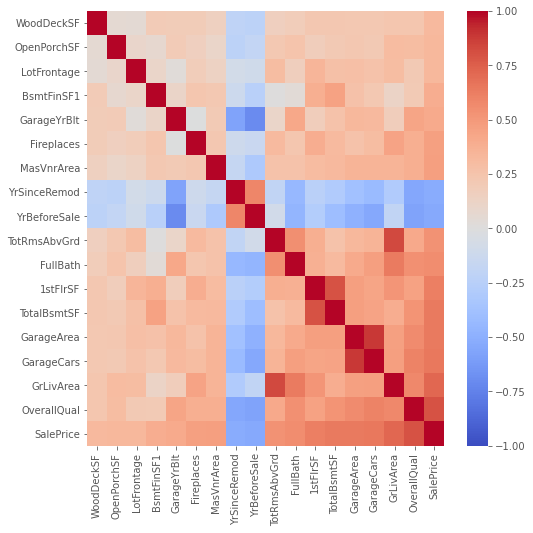

In [43]:
## Correlation heatmap to identify linear features 
%matplotlib inline
import seaborn as sns
strong_corrs = sorted_corrs[sorted_corrs > 0.3]
corrmat = numerical_train[strong_corrs.index].corr()
plt.figure(figsize=(8,8))
sns.heatmap(corrmat,
            vmin=-1,
            cmap='coolwarm');

It seems like Overall Qual and the Gr Liv Area are the two features with the highest correlation with Sale Price. From the heatmap we also see that there is a linear relation between the following features:
 * TotRms AbvGrd - Gr Liv Area: Number of rooms depends on the living area
 * GarageCars - GarageArea: Size of garage in two different units
 * 1stFlrSF - TotalBsmtSF: Total basement area depends on the size of the 1st floor
 * GarageYrBlt - YrBeforeSale: The garage is usually built in the same year as the house

Therefore we can drop TotRms AbvGrd, GarageCars, 1stFlrSF and GarageYrBlt from our features.

In [44]:
transform_train = numerical_train.drop(['TotRmsAbvGrd','GarageCars','1stFlrSF','GarageYrBlt'],axis=1)

We can further narrow down the features by keeping only the columns with a correlation coefficient larger than 0.4, which seems to be a natural cutoff point for this dataset.

In [45]:
abs_corr_coeffs = transform_train.corr()['SalePrice'].abs().sort_values()
abs_corr_coeffs[abs_corr_coeffs > 0.4]

Fireplaces      0.466395
MasVnrArea      0.469476
YrSinceRemod    0.521843
YrBeforeSale    0.534428
FullBath        0.558772
TotalBsmtSF     0.645455
GarageArea      0.647449
GrLivArea       0.720022
OverallQual     0.800121
SalePrice       1.000000
Name: SalePrice, dtype: float64

In [46]:
transform_train = transform_train.drop(abs_corr_coeffs[abs_corr_coeffs < 0.4].index, axis=1)
num_cols_to_keep = transform_train.columns

## Feature Filtering - Categorical

Next we can look at which categorical columns we can keep for the machine learning model.

In [47]:
cat_train = train.select_dtypes(exclude=[np.number])
cat_train.describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature
count,1451,1451,1451,1451,1451,1451,1451,1451,1451,1451,...,1451,1451,1451,1451,1451,1451,1451,1451,1451,1451
unique,5,2,3,4,4,2,5,3,25,9,...,7,6,7,4,6,6,3,4,5,5
top,RL,Pave,No,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Typ,No,Attchd,Unf,TA,TA,Y,No,No,No
freq,1143,1446,1360,920,1306,1450,1046,1374,225,1254,...,1351,688,865,605,1302,1317,1331,1446,1171,1398


In [48]:
## Convert the columns into categorical type
text_cols = cat_train.columns
mod_cat_train = cat_train.copy()
for col in text_cols:
    mod_cat_train[col] = cat_train[col].astype('category')
## How many unique values in each categorical column?
    uniq = np.unique(cat_train[col])
    print('{}: {} unique values -  {}'.format(col,len(uniq),uniq))

MSZoning: 5 unique values -  ['C (all)' 'FV' 'RH' 'RL' 'RM']
Street: 2 unique values -  ['Grvl' 'Pave']
Alley: 3 unique values -  ['Grvl' 'No' 'Pave']
LotShape: 4 unique values -  ['IR1' 'IR2' 'IR3' 'Reg']
LandContour: 4 unique values -  ['Bnk' 'HLS' 'Low' 'Lvl']
Utilities: 2 unique values -  ['AllPub' 'NoSeWa']
LotConfig: 5 unique values -  ['Corner' 'CulDSac' 'FR2' 'FR3' 'Inside']
LandSlope: 3 unique values -  ['Gtl' 'Mod' 'Sev']
Neighborhood: 25 unique values -  ['Blmngtn' 'Blueste' 'BrDale' 'BrkSide' 'ClearCr' 'CollgCr' 'Crawfor'
 'Edwards' 'Gilbert' 'IDOTRR' 'MeadowV' 'Mitchel' 'NAmes' 'NPkVill'
 'NWAmes' 'NoRidge' 'NridgHt' 'OldTown' 'SWISU' 'Sawyer' 'SawyerW'
 'Somerst' 'StoneBr' 'Timber' 'Veenker']
Condition1: 9 unique values -  ['Artery' 'Feedr' 'Norm' 'PosA' 'PosN' 'RRAe' 'RRAn' 'RRNe' 'RRNn']
Condition2: 7 unique values -  ['Artery' 'Feedr' 'Norm' 'PosA' 'RRAe' 'RRAn' 'RRNn']
BldgType: 5 unique values -  ['1Fam' '2fmCon' 'Duplex' 'Twnhs' 'TwnhsE']
HouseStyle: 8 unique values

After converting the categorical columns, we confirmed that they all have at least 2 distinct values. Similarly to numerical columns, we can check correlations between the categorical features to eliminate linear relations between distinct features. This gets really complicated after we apply one-hot encoding since we end up with a really large correlation table (216 in this case). Therefore we need to use Cramer's V, which is a measure of association between two nominal variables, giving a value between 0 and +1. For this, we need a categorical representation of the target variable sale price: 

In [49]:
mod_cat_train['SalePriceCat'] = pd.cut(train['SalePrice'],np.arange(0, 700000, 50000),include_lowest=True,right=False)
mod_cat_train['SalePriceCat'].value_counts()

[100000, 150000)    501
[150000, 200000)    406
[200000, 250000)    210
[250000, 300000)    109
[50000, 100000)     108
[300000, 350000)     59
[350000, 400000)     27
[400000, 450000)     14
[0, 50000)            5
[450000, 500000)      5
[550000, 600000)      3
[500000, 550000)      2
[600000, 650000)      2
Name: SalePriceCat, dtype: int64

In [50]:
mod_cat_train.isnull().sum().value_counts()

0    42
dtype: int64

This way, we have a full categorical dataset with no missing values that we can use to find associations with. This will help us further filter features for use with the machine learning model.

The functions we need were already developed by Shaked Zychlinski in his GitHub page:

https://github.com/shakedzy/dython

He also has the following article to explain his approach:

https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

In the following we will simplify it for our case, in which we already converted the values into categorical and thus only need Cramer's V:

In [51]:
import scipy.stats as ss
def cramers_v(x,y):
    """
    Calculates Cramer's V statistic for categorical-categorical association.
    This is a symmetric coefficient: V(x,y) = V(y,x)

    Original function taken from: https://stackoverflow.com/a/46498792/5863503
    Wikipedia: https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

    Parameters:
    -----------
    x : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements
    y : list / NumPy ndarray / Pandas Series
        A sequence of categorical measurements

    Returns:
    --------
    float in the range of [0,1]
    """
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

In [52]:
def associations(dataset):
    """
    Calculate the strength-of-association of features in data-set
    with categorical features using Cramer's V for categorical-categorical cases

    Parameters:
    -----------
    dataset : NumPy ndarray / Pandas DataFrame
        The data-set for which the features' correlation is computed

    Returns:
    --------
    A dictionary with the following keys:
    - `corr`: A DataFrame of the correlation/strength-of-association between
    all features

    """
    columns = dataset.columns
    corr = pd.DataFrame(index=columns, columns=columns)  # will be used to store associations values

    # computing associations
    for i in range(0, len(columns)):
        for j in range(i, len(columns)):
            if i == j:
                corr.loc[columns[i], columns[j]] = 1.0
            else:
                cell = cramers_v(dataset[columns[i]], dataset[columns[j]])
                ij = cell
                ji = cell
                corr.loc[columns[i], columns[j]] = ij
                corr.loc[columns[j], columns[i]] = ji

    return corr

In [53]:
cat_corr = associations(mod_cat_train)
cat_corr = cat_corr.astype('float')
sorted_cat_corrs = cat_corr['SalePriceCat'].sort_values()
sorted_cat_corrs

Utilities       0.036163
Street          0.038115
PoolQC          0.065770
MiscFeature     0.074242
Condition2      0.074579
Condition1      0.100359
LandSlope       0.102299
RoofMatl        0.109802
Functional      0.110515
LotConfig       0.128852
BsmtFinType2    0.131219
BldgType        0.133167
Heating         0.147987
ExterCond       0.150994
RoofStyle       0.151674
Fence           0.152307
Alley           0.157847
LandContour     0.163701
HouseStyle      0.168415
Exterior1st     0.171195
Exterior2nd     0.173832
Electrical      0.174464
BsmtCond        0.179937
GarageCond      0.212562
LotShape        0.219893
BsmtFinType1    0.219918
BsmtExposure    0.229089
PavedDrive      0.239054
GarageQual      0.240828
MasVnrType      0.257075
HeatingQC       0.269145
Foundation      0.269543
GarageType      0.275877
FireplaceQu     0.307837
MSZoning        0.309258
Neighborhood    0.316372
GarageFinish    0.415681
BsmtQual        0.438642
CentralAir      0.462954
KitchenQual     0.477928


Looking at the correlations, 0.2 seems to be a good cutoff point for the categorical features.

In [54]:
strong_cat_corrs = sorted_cat_corrs[sorted_cat_corrs > 0.2]
cat_corrmat = associations(mod_cat_train[strong_cat_corrs.index])
cat_corrmat = cat_corrmat.astype('float')

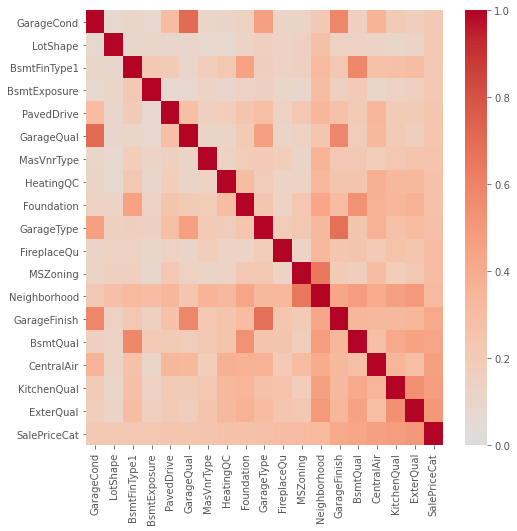

In [55]:
## Association heatmap to identify linear features 
plt.figure(figsize=(8,8))
sns.heatmap(cat_corrmat,
            vmin=0,
            center=0,
            cmap='coolwarm');

From these associations, it seems like there is a linear relation between:
* MSZoning and Neighborhood
* GarageCond, GarageType, GarageQual and GarageFinish
* BsmtFinType1 and BsmtQual

Since Neighborhood has 25 unique values, we can use MSZoning instead. From the garage features, we can use GarageQual since it seems to summarize all the different qualities in a single feature. Similarly for the basement features, we can use BsmtQual.

In [56]:
mod_cat_train = mod_cat_train.drop(sorted_cat_corrs[sorted_cat_corrs < 0.2].index, axis=1)

In [57]:
drop_cat_cols = ['Neighborhood','GarageCond','GarageType','GarageQual','BsmtFinType1','BsmtExposure']
mod_cat_train = mod_cat_train.drop(drop_cat_cols, axis=1)

In [58]:
mod_cat_train = mod_cat_train.drop('SalePriceCat', axis=1)
cat_cols_to_keep = mod_cat_train.columns
mod_cat_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1451 entries, 0 to 1459
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   MSZoning      1451 non-null   category
 1   LotShape      1451 non-null   category
 2   MasVnrType    1451 non-null   category
 3   ExterQual     1451 non-null   category
 4   Foundation    1451 non-null   category
 5   BsmtQual      1451 non-null   category
 6   HeatingQC     1451 non-null   category
 7   CentralAir    1451 non-null   category
 8   KitchenQual   1451 non-null   category
 9   FireplaceQu   1451 non-null   category
 10  GarageFinish  1451 non-null   category
 11  PavedDrive    1451 non-null   category
dtypes: category(12)
memory usage: 30.6 KB


In [59]:
## Create dummy columns and add back to the dataframe!
transform_train = pd.concat([transform_train, pd.get_dummies(mod_cat_train)], axis=1)
transform_train.head()

,OverallQual,MasVnrArea,TotalBsmtSF,GrLivArea,FullBath,Fireplaces,GarageArea,SalePrice,YrBeforeSale,YrSinceRemod,...,FireplaceQu_No,FireplaceQu_Po,FireplaceQu_TA,GarageFinish_Fin,GarageFinish_No,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_N,PavedDrive_P,PavedDrive_Y
0,7,196.0,856,1710,2,0,548,208500,5,5,...,1,0,0,0,0,1,0,0,0,1
1,6,0.0,1262,1262,2,1,460,181500,31,31,...,0,0,1,0,0,1,0,0,0,1
2,7,162.0,920,1786,2,1,608,223500,7,6,...,0,0,1,0,0,1,0,0,0,1
3,7,0.0,756,1717,1,1,642,140000,91,36,...,0,0,0,0,0,0,1,0,0,1
4,8,350.0,1145,2198,2,1,836,250000,8,8,...,0,0,1,0,0,1,0,0,0,1


In [60]:
transform_train.shape

(1451, 63)

We have to apply the same transformation to the test dataset:

In [61]:
cols_to_keep = num_cols_to_keep.tolist() + cat_cols_to_keep.tolist()
cols_to_keep.remove('SalePrice')
mod_test = test[cols_to_keep]
text_cols = mod_test.select_dtypes(include=['object'])
cat_test = mod_test.copy()
for col in text_cols:
    cat_test[col] = mod_test[col].astype('category')
    
transform_test = pd.concat([cat_test, 
                            pd.get_dummies(cat_test.select_dtypes(include=['category']))], axis=1).drop(text_cols,axis=1)
transform_test.head()

,OverallQual,MasVnrArea,TotalBsmtSF,GrLivArea,FullBath,Fireplaces,GarageArea,YrBeforeSale,YrSinceRemod,MSZoning_C (all),...,FireplaceQu_No,FireplaceQu_Po,FireplaceQu_TA,GarageFinish_Fin,GarageFinish_No,GarageFinish_RFn,GarageFinish_Unf,PavedDrive_N,PavedDrive_P,PavedDrive_Y
0,5,0.0,882.0,896,1,0,730.0,49,49,0,...,1,0,0,0,0,0,1,0,0,1
1,6,108.0,1329.0,1329,1,0,312.0,52,52,0,...,1,0,0,0,0,0,1,0,0,1
2,5,0.0,928.0,1629,2,1,482.0,13,12,0,...,0,0,1,1,0,0,0,0,0,1
3,6,20.0,926.0,1604,2,1,470.0,12,12,0,...,0,0,0,1,0,0,0,0,0,1
4,8,0.0,1280.0,1280,2,0,506.0,18,18,0,...,1,0,0,0,0,1,0,0,0,1


In [62]:
transform_test.shape

(1459, 62)

## Linear Regression

Now that we have the transformed datasets for training and test data, we can train a linear model. As discussed previously, Kaggle evaluates the submissions on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price:

In [63]:
y = np.log(transform_train.SalePrice)
X = transform_train.drop(['SalePrice'], axis=1)

Now we can partition the training set with a fixed random state for reproducible results:

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                          X, y, random_state=42, test_size=.33)

Next we can fit the model and check the R^2 value to see how the model fits the data:

In [65]:
from sklearn import linear_model
lr = linear_model.LinearRegression()
model = lr.fit(X_train, y_train)
print ("R^2 is: \n", model.score(X_test, y_test))

R^2 is: 
 0.8670306087108623


So the model explains approximately 87% of the variance in our target variable. Next we can make predictions using the holdout data:

In [66]:
from sklearn.metrics import mean_squared_error
predictions = model.predict(X_test)
print ('RMSE is: \n', mean_squared_error(y_test, predictions))

RMSE is: 
 0.018350952963703926


If we plot the actual prices vs. predicted prices, we can see how much the predictions deviate from the actual prices:

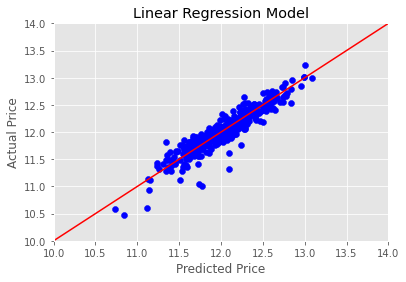

In [67]:
actual_values = y_test
plt.scatter(predictions, actual_values, color='b')
plt.axline((0, 0), slope=1, color='r')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.xlim(10, 14)
plt.ylim(10, 14)
plt.show()

## Result Submission

The file we need to submit to Kaggle should have the form:

    Id,SalePrice
    1461,169000.1
    1462,187724.1233

In [68]:
submission = pd.DataFrame()
submission['Id'] = test.Id
predictions = model.predict(transform_test)

Now we’ll transform the predictions to the correct form:

In [69]:
final_predictions = np.exp(predictions)
print ("Original predictions are: \n", predictions[:5], "\n")
print ("Final predictions are: \n", final_predictions[:5])

Original predictions are: 
 [11.68143111 11.89642244 12.07220639 12.11331022 12.20455622] 

Final predictions are: 
 [118353.49033358 146740.71190989 174941.40854101 182282.00006313
 199696.94403487]


Now that we have the prices in the correct scale, we can fill the submission data:

In [70]:
submission['SalePrice'] = final_predictions
submission.head()

,Id,SalePrice
0,1461,118353.490334
1,1462,146740.711910
2,1463,174941.408541
3,1464,182282.000063
4,1465,199696.944035


In [71]:
submission.to_csv('submission1.csv', index=False)

This submission scored 0.155 on the test data which is placed 3424 out of 5375 at the time of this writing. So it could be regarded as an average result.

## Random Forest Regressor

Next we will try to improve the result by using the random forest regressor algorithm. We can use grid search to train using different combinations of hyperparameters to find the best performing model:

In [72]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor()

hyperparameters = {
    "n_estimators": [50, 100],
    "max_depth": [2, 5, 10],
    "max_features": ["auto", "sqrt", "log2"],
    "min_samples_split": [2, 5, 10]
}

grid = GridSearchCV(rf, param_grid=hyperparameters, cv=10)
model = grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_score_)

{'max_depth': 10, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 100}
0.8637114916296549


We can make predictions using this model:

In [73]:
predictions = model.predict(X_test)
print ('RMSE is: \n', mean_squared_error(y_test, predictions))

RMSE is: 
 0.02236039603858489


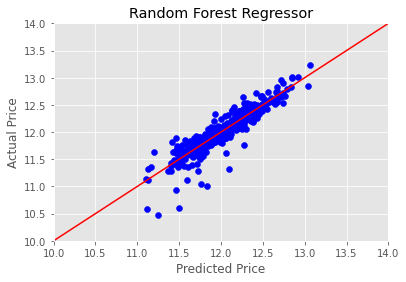

In [74]:
actual_values = y_test
plt.scatter(predictions, actual_values, color='b')
plt.axline((0, 0), slope=1, color='r')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Random Forest Regressor')
plt.xlim(10, 14)
plt.ylim(10, 14)
plt.show()

As seen, the error is slightly larger than the one we got with linear regression. Nonetheless, we can submit the results to Kaggle to see how the model performs on the test data:

In [75]:
submission2 = pd.DataFrame()
submission2['Id'] = test.Id
predictions = model.predict(transform_test)
final_predictions = np.exp(predictions)
submission2['SalePrice'] = final_predictions
submission2.head()

,Id,SalePrice
0,1461,125918.057429
1,1462,145775.837502
2,1463,177029.402154
3,1464,183125.870892
4,1465,209567.099327


In [76]:
submission2.to_csv('submission2.csv', index=False)

This submission scored 0.157 on the test data, which is not an improvement over the linear regression model as predicted in the previous step.

## Conclusions

Using the Ames Housing dataset from Kaggle, we were able to practice feature engineering, feature selection and making predictions using a linear regression and a random forest regressor. For the random forest regressor, we employed grid search to identify the best hyperparameters. Along the way, we were able to implement a function to find associations between categorical features using the Cramer's V. 

For our selection of features, we have shown that the linear regression model works slightly better than the random forest algorithm. Since our goal with this project was to work on feature engineering techniques with both numerical and categorical data, we will not work further on the models to improve the accuracy. The results could be improved by going back to the feature selection and using different filtering criteria or transforming other features.